In [ ]:
# ====================================================
# Phase 1: Data Preparation
# Project: Predictive Analytics for Supply Chain Optimization
# ====================================================

# --- 1. Import Required Libraries ---
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, classification_report, confusion_matrix
)


In [ ]:
try:
  df = pd.read_csv(r"C:\Users\BOB\Documents\Data Analysis\.data\dynamic_supply_chain_logistics_dataset.csv", encoding='utf-8')
except UnicodeDecodeError:
  df = pd.read_csv(r"C:\Users\BOB\Documents\Data Analysis\.data\dynamic_supply_chain_logistics_dataset.csv", encoding='latin-1')
print("Dataset loaded successfully!")

# Show list of columns
# print(df.columns)

In [ ]:
# --- 3. Basic Data Overview ---
print("Shape of dataset:", df.shape)
# print("\nColumns:\n", df.columns.tolist())
print("\nMissing values summary:\n", df.isna().sum())
print("\nData types:\n", df.dtypes)

In [ ]:
# Choose range and count
start_date = pd.to_datetime("2024-01-01")
end_date = pd.to_datetime("2024-12-31")

# Replace timestamp column with random dates
df['timestamp'] = pd.to_datetime(
    np.random.randint(
        start_date.value // 10**9,
        end_date.value // 10**9,
        len(df)
    ),
    unit='s'
)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# print(df.head())

In [ ]:
# --- 4. Handle Missing Values with NumPy ---
# Identify numeric columns, but exclude 'timestamp'
num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols = [col for col in num_cols if col != 'timestamp']

# Identify categorical columns
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()

# Impute numeric columns with median
for col in num_cols:
    median_val = np.nanmedian(df[col])
    df[col] = df[col].fillna(median_val)

# If 'timestamp' is datetime and has missing values, optionally impute separately
if df['timestamp'].isna().any():
    # Replace NaT with some default, e.g., first date
    df['timestamp'] = df['timestamp'].fillna(df['timestamp'].min())


# print(df['timestamp'].head())


In [ ]:
# Keep only rows where vehicle_gps_latitude >= 35
df = df[df['vehicle_gps_latitude'] >= 35]
df = df[df['vehicle_gps_longitude'] >= -110]
df = df[df['vehicle_gps_longitude'] <= -85]

In [ ]:
# Create vehicle_city column based on coordinates
# Suppose your df has Latitude and Longitude as numeric columns
# Round coordinates to 0 decimal places (~100 km grid)
df['lat_bin'] = df['vehicle_gps_latitude'].round(0)
df['lon_bin'] = df['vehicle_gps_longitude'].round(0)

# Create a pseudo city label
df['vehicle_city'] = df['lat_bin'].astype(str) + ", " + df['lon_bin'].astype(str)

# Optional: check unique values
print(df['vehicle_city'].head())



In [ ]:
# Add a unique ID for each row
df['row_id'] = range(1, len(df) + 1)

# Check
# print(df[['row_id', 'vehicle_gps_latitude', 'vehicle_gps_longitude']].head())


In [ ]:
# Categorical columns → replace NaN with most frequent value (mode)
for col in cat_cols:
    mode_val = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'
    df[col] = df[col].fillna(mode_val)

print("\n Missing values handled with NumPy (median/mode).")


In [ ]:
# --- 5. Feature Engineering ---

## 5.1 Create derived features
# Example: combine GPS into one column
df['vehicle_location'] = df['vehicle_gps_latitude'].astype(str) + ',' + df['vehicle_gps_longitude'].astype(str)

# Example: compute delay difference in minutes
df['eta_variation_minutes'] = df['eta_variation_hours'] * 60

# Example: categorize traffic level
df['traffic_category'] = pd.cut(
    df['traffic_congestion_level'],
    bins=[0, 3, 6, 10],
    labels=['Low', 'Medium', 'High']
)

# Example: flag if weather severity exceeds threshold
df['severe_weather_flag'] = np.where(df['weather_condition_severity'] > 7, 1, 0)

print("\n Feature engineering complete. New columns added:", 
      [c for c in df.columns if 'vehicle_location' in c or 'eta_variation_minutes' in c or 'traffic_category' in c or 'severe_weather_flag' in c])



In [47]:
# Identify which columns are categorical
cat_cols = df.select_dtypes(include=['object', 'category']).columns

# cat_cols = df.select_dtypes(exclude=np.number).columns
print("Categorical columns:", list(cat_cols))


Categorical columns: ['risk_classification', 'vehicle_city', 'vehicle_location', 'traffic_category']


In [ ]:
print(df.traffic_congestion_level.head())

In [ ]:
# --- 6. Encode Categorical Features ---

label_enc = LabelEncoder()
for col in cat_cols:
    df[col] = label_enc.fit_transform(df[col].astype(str))

# Check result
print(df[cat_cols].head())


print("\n Categorical encoding complete.")

    risk_classification  vehicle_city  vehicle_location  traffic_category
8                     2           147              1629                 0
17                    0           183              2357                 1
25                    0           128              1398                 2
33                    0           277              3191                 0
35                    2            25                84                 0

 Categorical encoding complete.


In [49]:
# --- 7. Remove Duplicates ---
initial_shape = df.shape
df.drop_duplicates(inplace=True)
print(f"\n Removed {initial_shape[0] - df.shape[0]} duplicate rows.")


 Removed 0 duplicate rows.


In [50]:
# --- 10. Save Cleaned Dataset ---
df.to_csv('cleaned_logistics_data.csv', index=False)
print("\n Cleaned dataset saved as 'cleaned_logistics_data.csv'.")



 Cleaned dataset saved as 'cleaned_logistics_data.csv'.


In [ ]:
# # --- 8. Scale Numerical Features ---
# scaler = StandardScaler()
# df[num_cols] = scaler.fit_transform(df[num_cols])
# print("\n Numerical features scaled.")

In [51]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
print("\n Numerical features scaled with Min-Max Scaler.")


 Numerical features scaled with Min-Max Scaler.


In [52]:
# --- 9. Final Dataset Summary ---
print("\nFinal dataset shape:", df.shape)
print("\nSample data:")
display(df.head())
# print(df.shipping_costs)


Final dataset shape: (5578, 34)

Sample data:


,timestamp,vehicle_gps_latitude,vehicle_gps_longitude,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,supplier_reliability_score,lead_time_days,historical_demand,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation,lat_bin,lon_bin,vehicle_city,row_id,vehicle_location,eta_variation_minutes,traffic_category,severe_weather_flag
8,2024-07-16 11:13:58,0.319122,0.764121,0.045378,0.994125,0.961316,0.109817,0.020500,0.049305,0.183042,0.868000,0.845226,0.427177,0.242227,0.344144,0.994265,8.052130e-07,0.914182,0.715884,0.371081,0.876879,0.996431,0.321187,0.223527,2,0.276943,40.0,-91.0,147,1,1629,297.532504,0,0
17,2024-12-09 22:02:49,0.470999,0.378335,0.066739,0.999234,0.147293,0.055212,0.860251,0.286445,0.845133,0.052157,0.130621,0.014826,0.018891,0.243462,0.035190,3.633830e-08,0.135197,0.498691,0.607153,0.675503,0.513400,0.989861,0.997020,0,0.063334,42.0,-101.0,183,2,2357,299.678144,1,0
25,2024-10-12 05:30:17,0.270626,0.482519,0.000792,0.980595,0.473047,0.061652,0.759500,0.263769,0.999889,0.975974,0.301094,0.626989,0.362142,0.995295,0.547009,4.909631e-01,0.000054,0.204691,0.640925,0.096113,0.730927,0.999986,0.926330,0,0.999903,39.0,-98.0,128,3,1398,291.849939,2,0
33,2024-04-30 05:02:42,0.648524,0.761405,0.993794,0.269726,0.869466,0.022763,0.216089,0.600112,0.967194,0.784470,0.999113,0.060724,0.981911,0.001604,0.994459,4.217911e-01,0.010098,0.690826,0.144589,0.710606,0.219789,0.998641,0.177602,0,0.267472,45.0,-91.0,277,4,3191,-6.714285,0,0
35,2024-07-28 07:27:11,0.012835,0.459613,0.033852,0.245045,0.973184,0.967045,0.003881,0.029390,0.296500,0.152799,0.738910,0.535708,0.995374,0.538911,0.995789,2.857528e-01,0.422151,0.650865,0.073794,0.103517,0.998147,0.690875,0.193168,2,0.770661,35.0,-99.0,25,5,84,-17.079914,0,0


In [53]:
df_sorted = df.sort_values(by='shipping_costs')
print(df_sorted.shipping_costs)

3485     0.000000e+00
31824    3.410417e-10
18787    5.031125e-08
23664    9.404565e-08
32037    1.167306e-07
             ...     
7677     9.999334e-01
22680    9.999585e-01
9378     9.999754e-01
6900     9.999791e-01
18849    1.000000e+00
Name: shipping_costs, Length: 5578, dtype: float64


In [54]:
# ====================================================
# Phase 2: Exploratory Data Analysis (EDA)
# ====================================================

# --- 1. Import Required Libraries ---

import seaborn as sns

# display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", context="notebook")

# Assume df is already loaded and cleaned from Phase 1
print(" DataFrame available with shape:", df.shape)

 DataFrame available with shape: (5578, 34)



 Top 10 correlations with delivery_time_deviation:
delivery_time_deviation        1.000000
port_congestion_level          0.020712
lon_bin                        0.020091
risk_classification            0.019930
vehicle_gps_longitude          0.019735
shipping_costs                 0.017415
row_id                         0.016084
driver_behavior_score          0.015386
disruption_likelihood_score    0.012223
cargo_condition_status         0.012129
Name: delivery_time_deviation, dtype: float64


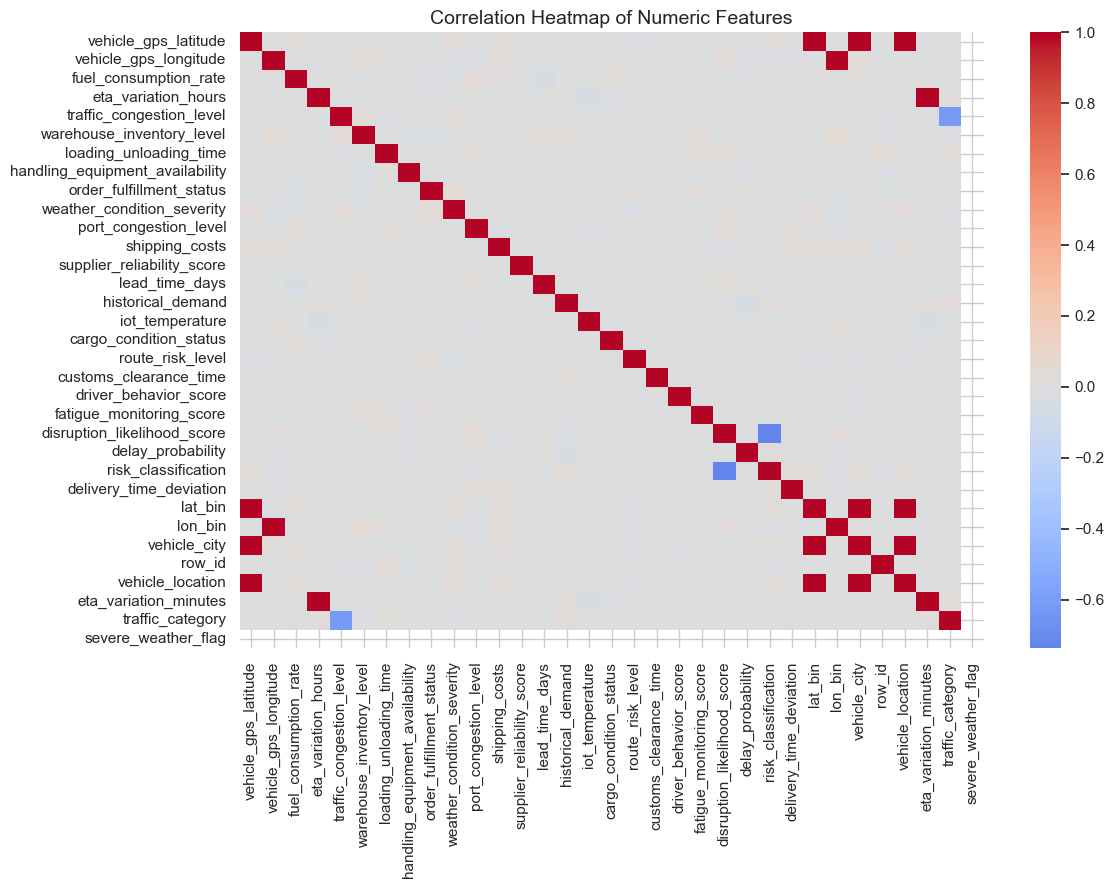

In [55]:
# ====================================================
# CORRELATION ANALYSIS
# ====================================================

# Select only numeric columns for correlation
numeric_cols = df.select_dtypes(include=np.number).columns #list of all numeric column names.
corr_matrix = df[numeric_cols].corr()

# Display top correlated features with delivery deviation
target = 'delivery_time_deviation'
if target in corr_matrix.columns:
    print("\n Top 10 correlations with delivery_time_deviation:")
    print(corr_matrix[target].abs().sort_values(ascending=False).head(10))

# Heatmap visualization
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
#sns.scatterplot(x='traffic_congestion_level_num', y='delivery_time_deviation', data=df)

plt.title("Correlation Heatmap of Numeric Features", fontsize=14)
plt.show()

In [ ]:
# ====================================================
# 3️ DISTRIBUTION ANALYSIS AND ANOMALY DETECTION
# ====================================================

# Plot distribution of key numeric variables
key_vars = [
    'delivery_time_deviation',
    'fuel_consumption_rate',
    'traffic_congestion_level',
    'shipping_costs',
    'lead_time_days'
]
key_vars = [v for v in key_vars if v in df.columns]

for col in key_vars:
    plt.figure(figsize=(7, 4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

In [ ]:
# Detect anomalies using IQR method for each key numeric column
def detect_outliers_iqr(series):
    q1, q3 = np.percentile(series.dropna(), [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return ((series < lower) | (series > upper)).sum()

outlier_summary = {col: detect_outliers_iqr(df[col]) for col in key_vars}
print("\n🔎 Outlier count per key variable:")
print(pd.Series(outlier_summary))

In [ ]:
# ====================================================
# 4️ SEASONAL & REGIONAL DELAY TRENDS
# ====================================================

# Convert timestamp to datetime if needed
if not np.issubdtype(df['timestamp'].dtype, np.datetime64):
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Extract time-based features
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['weekday'] = df['timestamp'].dt.day_name()

# --- 4.1 Seasonal trends (monthly average delay)
if 'delivery_time_deviation' in df.columns:
    monthly_delay = df.groupby('month')['delivery_time_deviation'].mean()
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=monthly_delay.index, y=monthly_delay.values, marker='o')
    plt.title(" Average Delivery Time Deviation by Month")
    plt.xlabel("Month")
    plt.ylabel("Avg Delivery Deviation")
    plt.show()

In [ ]:
# --- 4.2 Regional trends (by city or location if available)
if 'Customer City' in df.columns:
    regional_delay = df.groupby('Customer City')['delivery_time_deviation'].mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=regional_delay.values, y=regional_delay.index, palette='coolwarm')
    plt.title(" Top 10 Cities by Average Delivery Deviation")
    plt.xlabel("Average Delay")
    plt.ylabel("City")
    plt.show()
else:
    print("\n No 'Customer City' column found for regional analysis. Skipping.")

In [ ]:
# --- 4.3 Weekday delay trends
if 'delivery_time_deviation' in df.columns:
    weekday_delay = df.groupby('weekday')['delivery_time_deviation'].mean()
    plt.figure(figsize=(8, 4))
    sns.barplot(x=weekday_delay.index, y=weekday_delay.values, palette='crest')
    plt.title(" Average Delivery Deviation by Weekday")
    plt.xlabel("Weekday")
    plt.ylabel("Avg Delivery Deviation")
    plt.xticks(rotation=45)
    plt.show()

print("\n Phase 2: EDA completed successfully.")


In [ ]:
# ====================================================
# Phase 3: Machine Learning Modeling
# ====================================================



# Assume df is already loaded and cleaned from previous phases
print(" DataFrame ready with shape:", df.shape)


# ====================================================
# 2️ FEATURE SELECTION & ENCODING
# ====================================================

# Drop non-numeric / irrelevant columns
exclude_cols = ['timestamp', 'Customer City', 'Customer Email', 'Customer Fname', 'Customer Lname']
df = df.drop(columns=[c for c in exclude_cols if c in df.columns], errors='ignore')

# Encode categorical variables
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Replace remaining NaNs with median
df = df.fillna(df.median(numeric_only=True))



In [ ]:

# Drop non-relevant identifier columns (keep numeric & categorical features only)
exclude_cols = [
    'timestamp', 'Customer City', 'Customer Email',
    'Customer Fname', 'Customer Lname'
]
df = df.drop(columns=[c for c in exclude_cols if c in df.columns], errors='ignore')

# Identify categorical and numeric columns
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=[np.number]).columns

print("Categorical columns:", list(cat_cols))
print("Numeric columns:", list(num_cols))

# Encode categorical columns safely using LabelEncoder
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

for col in cat_cols:
    df[col] = encoder.fit_transform(df[col].astype(str))

# Fill NaN with median for numeric, mode for categorical
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("All categorical features encoded successfully. Ready for modeling.")


In [ ]:
# ====================================================
# 🔧 DATA CLEANUP BEFORE MODELING — FINAL SAFE VERSION
# ====================================================


# Work on a copy to preserve df
data = df.copy()

# Drop identifier or irrelevant columns if they exist
drop_cols = [
    'timestamp', 'Customer City', 'Customer Email',
    'Customer Fname', 'Customer Lname'
]
data = data.drop(columns=[c for c in drop_cols if c in data.columns], errors='ignore')

# --- 1. Convert booleans to int
bool_cols = data.select_dtypes(include=['bool']).columns
if len(bool_cols):
    data[bool_cols] = data[bool_cols].astype(int)

# --- 2. Encode categoricals (object / category)
cat_cols = data.select_dtypes(include=['object', 'category']).columns
if len(cat_cols):
    print("Encoding categorical columns:", list(cat_cols))
    for col in cat_cols:
        data[col] = data[col].astype(str).astype('category').cat.codes

# --- 3. Replace any infinite or missing values
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(data.median(numeric_only=True))

# --- 4. Enforce numeric dtype globally
data = data.apply(pd.to_numeric, errors='coerce').fillna(0)

# --- 5. Verify everything is numeric
non_numeric = data.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print(" Still non-numeric columns:", non_numeric)
else:
    print(" All columns successfully converted to numeric.")

#  Ready for modeling
df = data


In [ ]:
# --- Phase 3: Model Training with Progress Bar ---

#!pip install tqdm --quiet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report
from tqdm.notebook import tqdm  # progress bar for Jupyter

# --- Example target columns ---
target_reg = "delivery_time_deviation"
target_cls = "risk_classification"

# --- Ensure numeric features only ---
X = df.select_dtypes(include=[np.number])
y_reg = df[target_reg]
y_cls = df[target_cls].astype(str)  # ensure string for classification

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# --- Scale numeric features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Models ---
models_reg = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(
        n_estimators=50, max_depth=10, n_jobs=-1, random_state=42
    )
}

# --- Results dict ---
results_reg = {}

# --- Model training with progress bar ---
print(" Training regression models...")
for name in tqdm(models_reg.keys(), desc="Training Progress", leave=False):
    model = models_reg[name]
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    
    results_reg[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}
    print(f"\n {name} done.")
    print(f"MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")

# --- Display summary ---
results_reg_df = pd.DataFrame(results_reg).T
display(results_reg_df.style.background_gradient(cmap="Blues").format("{:.3f}"))


In [ ]:
# Global storage for trained models
trained_models = {
    "regression": {},
    "classification": {}
}

In [ ]:
# ====================================================
# Phase 3: Machine Learning Modeling (Optimized)
# ====================================================

from tqdm.notebook import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report

# --- 1️ Preprocessing: ensure numeric ---
df_ml = df.copy()

# Drop identifier columns
drop_cols = ['timestamp', 'Customer City', 'Customer Email', 'Customer Fname', 'Customer Lname']
df_ml = df_ml.drop(columns=[c for c in drop_cols if c in df_ml.columns], errors='ignore')

# Encode booleans
bool_cols = df_ml.select_dtypes(include='bool').columns
df_ml[bool_cols] = df_ml[bool_cols].astype(int)

# Encode categorical columns
cat_cols = df_ml.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    df_ml[col] = LabelEncoder().fit_transform(df_ml[col].astype(str))

# Fill NaNs
df_ml = df_ml.fillna(df_ml.median(numeric_only=True))

print(" Preprocessing complete. Data ready for modeling.")

# --- 2️ Regression: delivery_time_deviation ---
if 'delivery_time_deviation' in df_ml.columns:
    print("\n Regression: delivery_time_deviation")

    X_reg = df_ml.drop(columns=['delivery_time_deviation'])
    y_reg = df_ml['delivery_time_deviation']

    # --- Optional: sample for speed ---
    sample_size = 5000
    if len(X_reg) > sample_size:
        X_reg = X_reg.sample(sample_size, random_state=42)
        y_reg = y_reg.loc[X_reg.index]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Models
    models_reg = {
        "Linear Regression": LinearRegression(),
        "Random Forest Regressor": RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
    }

    results_reg = {}
    for name in tqdm(models_reg.keys(), desc="Regression Models", leave=False):
        model = models_reg[name]
        start = pd.Timestamp.now()
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
        elapsed = (pd.Timestamp.now() - start).total_seconds()

        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        r2 = r2_score(y_test, preds)

        results_reg[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}
        print(f"\n {name} done in {elapsed:.2f} sec | MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")

        # Feature importance for Random Forest
        if hasattr(model, 'feature_importances_'):
            feat_imp = pd.Series(model.feature_importances_, index=X_reg.columns)
            feat_imp.nlargest(10).plot(kind='barh', figsize=(8,4), title=f"Top 10 Feature Importances ({name})")
            plt.show()

# --- 3️ Classification: risk_classification & delay_probability ---
def run_classification(target_col):
    print(f"\n Classification: {target_col}")
    if target_col not in df_ml.columns:
        print(f" Column '{target_col}' not found. Skipping.")
        return

    X = df_ml.drop(columns=[target_col])
    y = df_ml[target_col]

    # Optional sampling
    sample_size = 5000
    if len(X) > sample_size:
        X = X.sample(sample_size, random_state=42)
        y = y.loc[X.index]

    # Encode target
    y = LabelEncoder().fit_transform(y.astype(str))

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Models
    models_cls = {
        "Logistic Regression": LogisticRegression(max_iter=500),
        "Random Forest Classifier": RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
    }

    for name in tqdm(models_cls.keys(), desc=f"{target_col} Models", leave=False):
        model = models_cls[name]
        start = pd.Timestamp.now()
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
        # --- Save trained model globally ---
        trained_models['classification'][f"{target}_{name}"] = model
        elapsed = (pd.Timestamp.now() - start).total_seconds()

        acc = accuracy_score(y_test, preds)
        print(f"\n {name} done in {elapsed:.2f} sec | Accuracy: {acc:.3f}")

# Run classification tasks
for target in ['risk_classification', 'delay_probability']:
    run_classification(target)

print("\n Phase 3: Machine Learning Modeling completed successfully.")


In [ ]:
# ====================================================
# Phase 4: Insights & Recommendations
# ====================================================


print(" Phase 4: Interpreting model outputs and generating recommendations")

# --- 1️ Regression Insights: delivery_time_deviation ---
if 'delivery_time_deviation' in df_ml.columns:
    print("\n🔹 Regression Insights: Top drivers of delivery time deviation")

    # Use the last trained Random Forest model from Phase 3
    rf_model = models_reg.get("Random Forest Regressor", None)

    if rf_model is not None:
        # Feature importance
        feat_imp = pd.Series(rf_model.feature_importances_, index=X_reg.columns).sort_values(ascending=False)
        top_features = feat_imp.head(10)
        print("\nTop 10 features driving delivery time deviation:")
        display(top_features)

        # Visualize
        plt.figure(figsize=(8,5))
        sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")
        plt.title("Top 10 Feature Importances — Delivery Time Deviation")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.show()

        # Recommendations
        print("\n Recommendations based on top features:")
        for feat in top_features.index:
            print(f"- Monitor and optimize {feat} to reduce delivery time deviations.")


In [ ]:
# --- Classification Insights ---
for target in ['risk_classification', 'delay_probability']:
    print(f"\n🔹 Classification Insights: {target}")

    # Access the trained Random Forest Classifier from the global dictionary
    rf_model_cls = trained_models['classification'].get(f"{target}_Random Forest Classifier", None)

    if rf_model_cls is not None:
        # Ensure we use the same features as in training
        X_train_cls = df_ml.select_dtypes(include=[np.number]).drop(columns=[target], errors='ignore')

        # Feature importance
        feat_imp_cls = pd.Series(rf_model_cls.feature_importances_, index=X_train_cls.columns).sort_values(ascending=False)
        top_features_cls = feat_imp_cls.head(10)

        print("\nTop 10 features driving classification outcome:")
        display(top_features_cls)


        
        plt.figure(figsize=(8,5))
        sns.barplot(x=top_features_cls.values, y=top_features_cls.index, palette="magma")
        plt.title(f"Top 10 Feature Importances — {target}")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.show()

        # Recommendations
        print("\n Recommendations based on top features:")
        for feat in top_features_cls.index:
            print(f"- Investigate and improve {feat} to reduce {target.replace('_',' ')} risks.")
    else:
        print(f" No trained model found for {target}, skipping.")
